In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import keras
from tensorflow.keras.optimizers import Adam

In [2]:
### Step 2: Load and Preprocess Data
dataset_folder = 'C:\\Users\\solan\\Downloads\\Dataset\\'
width, height = 224, 224
categories = ['Domestic', 'Wild']
data = []
labels = []

In [3]:
for category_id, category in enumerate(categories):
    category_folder = os.path.join(dataset_folder, category)
    for species_folder in os.listdir(category_folder):
        species_folder_path = os.path.join(category_folder, species_folder)
        if os.path.isdir(species_folder_path):  # Check if it's a directory
            for image_name in os.listdir(species_folder_path):
                image_path = os.path.join(species_folder_path, image_name)
                image = load_img(image_path, target_size=(height, width))
                image = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
                data.append(image)
                labels.append(category_id)

In [4]:
X = np.array(data)
y = np.array(labels)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
### Step 3: Model Definition (Improved)
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(width, height, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Increased hidden layer size
    BatchNormalization(),
    Dropout(0.3),  # Increased dropout rate for regularization

    Dense(len(categories), activation='sigmoid')
])

In [7]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


In [10]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,  # Increased epochs for potentially better learning
                    callbacks=[reduce_lr, early_stopping],
                   validation_data=(X_test,y_test))

Epoch 1/20
125/125 [==============================] - 191s 2s/step - loss: 0.6196 - accuracy: 0.8058 - val_loss: 0.7605 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 187s 1s/step - loss: 0.5695 - accuracy: 0.8363 - val_loss: 0.6704 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 183s 1s/step - loss: 0.5694 - accuracy: 0.8462 - val_loss: 0.7480 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 177s 1s/step - loss: 0.5400 - accuracy: 0.8870 - val_loss: 1.2308 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 180s 1s/step - loss: 0.5891 - accuracy: 0.8992 - val_loss: 0.9461 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 6/20
125/125 [==============================] - 181s 1s/step - loss: 0.4740 - accuracy: 0.9620 - val_loss: 0.6742 - val_accuracy: 0.8340 - lr: 2.0000e-04
Epoch 7/20
125/125 [==============================] - 187s 1

In [11]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

32/32 [==============================] - 6s 181ms/step - loss: 0.4879 - accuracy: 0.8600
Test Loss: 0.48792579770088196, Test Accuracy: 0.8600000143051147


In [12]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

32/32 [==============================] - 6s 180ms/step


In [13]:
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=categories))

Classification Report:
              precision    recall  f1-score   support

    Domestic       0.86      0.86      0.86       500
        Wild       0.86      0.86      0.86       500

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



In [17]:
model.save('Custom_CNN_Animal_classifier_model.h5')

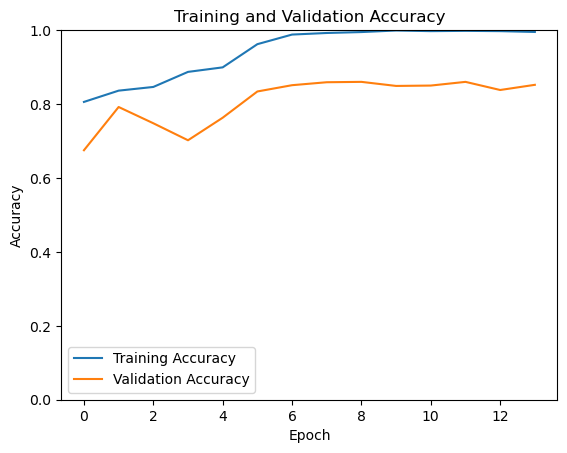

In [15]:
### Step 10: Visualization
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

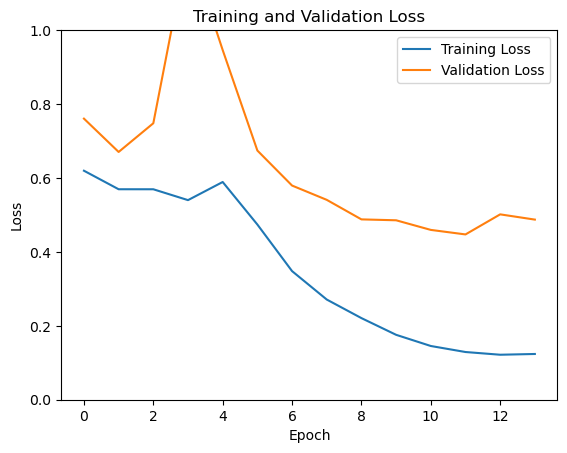

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

In [18]:
from tensorflow.keras.models import load_model

saved_model_path = 'Custom_CNN_Animal_classifier_model.h5'
loaded_model = load_model(saved_model_path)

def predict_image(image_path):
    # Load the image and preprocess it
    image = load_img(image_path, target_size=(height, width))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Make prediction
    prediction = loaded_model.predict(image)
    predicted_label = np.argmax(prediction)

    # Display prediction
    print("Predicted:", categories[predicted_label])

# Get image path from user input
image_path = input("Enter the path to the image: ")

# Check prediction for the input image
predict_image(image_path)

Enter the path to the image:  C:\Users\solan\Downloads\lion.jpeg


1/1 [==============================] - 0s 102ms/step
Predicted: Wild
